In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from utils import *
from SACFACT.Explainer import *
import matplotlib.pyplot as plt
from scipy.io import arff

In [2]:
def encode_label(label):
  if label == b'tested_positive': 
    return 1
  return 0
label_list = {0: 'negative', 1: 'positive'}


data = arff.loadarff('./Datasets/dataset_37_diabetes.arff')
dataset = pd.DataFrame(data[0])
dataset['label'] = dataset.apply(lambda row : encode_label(row['class']), axis = 1)

#dataset = data.sample(frac = 1)

X = dataset[['preg','plas','pres','skin','insu','mass','pedi','age']].values
y = dataset['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


#k = 5
#sk_lof = LocalOutlierFactor(n_neighbors=k, novelty=True)
sk_lof = IsolationForest(n_estimators=100, max_samples='auto')
sk_lof.fit(X)
#sk_lof_scores = np.negative(sk_lof.negative_outlier_factor_)
#print(sk_lof_scores[:10])

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       100
           1       0.67      0.65      0.66        54

    accuracy                           0.77       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154



IsolationForest()

/home/fatimaezzedine/.local/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(
2023-08-11 15:40:44.891600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 15:40:44.974285: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 15:40:44.992081: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been r

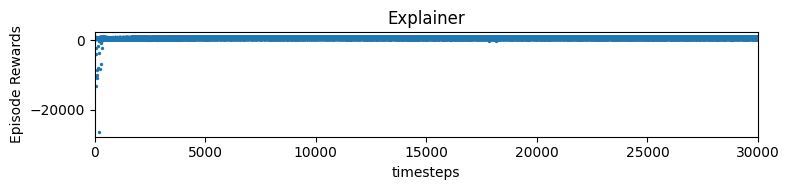

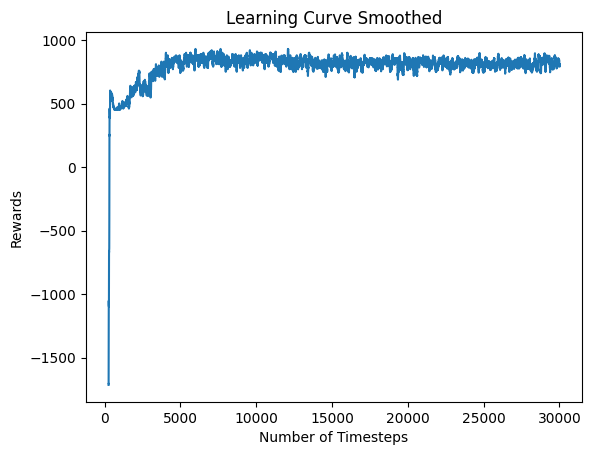

In [5]:
index = 15
point_to_be_explained = GenPoint(dataset.loc[index]['class'], dataset.loc[index]['label'])
point_to_be_explained.set_position(list(dataset.loc[index].values[:8]))
data = dataset[['preg','plas','pres','skin','insu','mass','pedi','age']]
target_class_explanation = 1 # for now it doeasnt matter I am telling the explainer to change the prediction without specifying the class - to be tested later
# to be changed in the code to take a specific class
explainer = Explainer(data, point_to_be_explained, target_class_explanation, clf, sk_lof, actor_critic = 'SAC', timesteps=30000)
explainer.train()

x, y = explainer.plot()
plt.show()
plt.plot(x,y)
plt.xlabel('Number of Timesteps')
plt.ylabel('Rewards')
plt.title('Learning Curve' + " Smoothed")
plt.show()

In [ ]:
report = explainer.report_counterfactuals()
non_anomalies = report[report['anomaly'] == 'Not Anomaly'].drop_duplicates(subset=['counterfactual']).reset_index(drop = True)
anomalies = report[report['anomaly'] == 'Anomaly'].drop_duplicates(subset=['counterfactual']).reset_index(drop = True)